In [5]:
from google.colab import files
uploaded = files.upload()


Saving Nasa_Dataset_Filtered_(3003_planets).csv to Nasa_Dataset_Filtered_(3003_planets).csv


In [6]:
import pandas as pd

df = pd.read_csv('Nasa_Dataset_Filtered_(3003_planets).csv')
print(f"Loaded {len(df)} planets.")
df.head()


Loaded 3002 planets.


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,soltype,pl_controv_flag,...,ra,decstr,dec,sy_dist,sy_vmag,sy_kmag,sy_gaiamag,rowupdate,pl_pubdate,releasedate
0,1RXS J160929.1-210524 b,1RXS J160929.1-210524,0,1,1,Imaging,2008,Gemini Observatory,Published Confirmed,0,...,242.376234,-21d04m59.31s,-21.083140,139.1350,12.61800,8.916,12.05720,2014-05-14,2008-12,2014-05-14
1,2MASS J02192210-3925225 b,2MASS J02192210-3925225,1,1,1,Imaging,2015,Cerro Tololo Inter-American Observatory,Published Confirmed,0,...,34.842705,-39d25m23.08s,-39.423077,NaN,NaN,10.404,15.01230,2015-05-14,2015-06,2015-05-14
2,55 Cnc e,55 Cnc,0,2,5,Radial Velocity,2004,McDonald Observatory,Published Confirmed,0,...,133.146837,+28d19m47.34s,28.329815,12.5855,5.95084,4.015,5.72973,2023-08-07,2018-09,2023-08-07
3,55 Cnc e,55 Cnc,0,2,5,Radial Velocity,2004,McDonald Observatory,Published Confirmed,0,...,133.146837,+28d19m47.34s,28.329815,12.5855,5.95084,4.015,5.72973,2021-02-05,2012-11,2014-05-16
4,55 Cnc e,55 Cnc,1,2,5,Radial Velocity,2004,McDonald Observatory,Published Confirmed,0,...,133.146837,+28d19m47.34s,28.329815,12.5855,5.95084,4.015,5.72973,2021-02-05,2018-10,2021-02-11


In [7]:
import pandas as pd
import numpy as np

# Load dataset
file_path = 'Nasa_Dataset_Filtered_(3003_planets).csv'
df = pd.read_csv(file_path)

# Drop rows with missing essential data
df = df.dropna(subset=['pl_rade', 'pl_insol', 'pl_orbeccen', 'pl_orbper', 'pl_eqt'])

# Ensure surface temperature column exists (if not, create with NaN)
if 'pl_surf_temp' not in df.columns:
    df['pl_surf_temp'] = np.nan

# Earth baseline values
EARTH = {
    'radius': 1.0,           # Earth radii
    'insolation': 1.0,       # Stellar flux relative to Earth
    'eccentricity': 0.0167,  # Earth's orbital eccentricity
    'orbital_period': 365.25, # days
    'surface_temp': 288,     # Kelvin
    'equilibrium_temp': 255  # Kelvin
}

# Feature weights
weights = {
    'radius': 0.25,
    'insolation': 0.25,
    'eccentricity': 0.10,
    'orbital_period': 0.10,
    'surface_temp': 0.15,
    'equilibrium_temp': 0.15
}

# Helper function to score feature based on absolute difference from Earth's value
# Score is 10 if exact match, linearly decreases to 0 when difference hits max_diff
def score_feature(value, earth_value, max_diff):
    diff = abs(value - earth_value)
    score = 10 * max(0, 1 - diff / max_diff)
    return score

# Define reasonable max differences for each feature (tune if needed)
max_diffs = {
    'radius': 1.0,            # difference up to 1 Earth radius away
    'insolation': 1.0,        # difference up to 1 Earth flux unit
    'eccentricity': 0.2,      # eccentricity difference up to 0.2
    'orbital_period': 200,    # up to 200 days difference
    'surface_temp': 100,      # Kelvin difference up to 100K
    'equilibrium_temp': 100   # Kelvin difference up to 100K
}

# Calculate scores for each feature
df['score_radius'] = df['pl_rade'].apply(lambda x: score_feature(x, EARTH['radius'], max_diffs['radius']))
df['score_insolation'] = df['pl_insol'].apply(lambda x: score_feature(x, EARTH['insolation'], max_diffs['insolation']))
df['score_eccentricity'] = df['pl_orbeccen'].apply(lambda x: score_feature(x, EARTH['eccentricity'], max_diffs['eccentricity']))
df['score_orbital_period'] = df['pl_orbper'].apply(lambda x: score_feature(x, EARTH['orbital_period'], max_diffs['orbital_period']))

# For temperature, prioritize surface temp if available, otherwise equilibrium temp
def temp_score(row):
    if not np.isnan(row['pl_surf_temp']):
        return score_feature(row['pl_surf_temp'], EARTH['surface_temp'], max_diffs['surface_temp'])
    else:
        return score_feature(row['pl_eqt'], EARTH['equilibrium_temp'], max_diffs['equilibrium_temp'])

df['score_temp'] = df.apply(temp_score, axis=1)

# Calculate weighted overall score out of 10
df['score'] = (
    df['score_radius'] * weights['radius'] +
    df['score_insolation'] * weights['insolation'] +
    df['score_eccentricity'] * weights['eccentricity'] +
    df['score_orbital_period'] * weights['orbital_period'] +
    df['score_temp'] * (weights['surface_temp'] + weights['equilibrium_temp'])
)

# Assign habitability category based on score
def categorize(score):
    if score >= 8:
        return 'Category 1'  # High habitability
    elif 6 <= score < 8:
        return 'Category 2'  # Moderate habitability
    else:
        return 'Category 3'  # Low habitability

df['habitability_category'] = df['score'].apply(categorize)

# Select top 100 planets by score
top_100 = df.sort_values(by='score', ascending=False).head(100)

# Save top 100 to CSV
top_100.to_csv('Top_100_Habitability.csv', index=False)

print("Done! Top 100 planets scored and saved to 'Top_100_Habitability.csv'.")


Done! Top 100 planets scored and saved to 'Top_100_Habitability.csv'.


In [8]:
top_100[['pl_name', 'score', 'habitability_category']]


,pl_name,score,habitability_category
2395,TRAPPIST-1 e,7.497500,Category 2
2393,TRAPPIST-1 d,6.816000,Category 2
2397,TRAPPIST-1 f,6.031000,Category 2
1145,Kepler-1661 b,5.687550,Category 3
1207,Kepler-22 b,5.370569,Category 3
...,...,...,...
529,HD 136352 b,1.756500,Category 3
1034,Kepler-107 b,1.743500,Category 3
629,HD 3167 b,1.741500,Category 3
998,Kepler-102 b,1.733500,Category 3


from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('habitability_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['habitability_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='score', y='habitability_category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
import pandas as pd

# Kepler-442b data as a dictionary
kepler_442b_data = {
    'pl_name': 'Kepler-442b',
    'pl_rade': 1.34,
    'pl_insol': 0.66,
    'pl_orbeccen': 0.04,
    'pl_orbper': 112.3,
    'pl_eqt': 233,
    'pl_bmasse': 2.36,
    'pl_gravity': 1.3,
    'sy_dist': 1196,
    'sy_vmag': 14.76,
    'sy_kmag': None,
    'sy_gaiamag': None,
    'discoverymethod': 'Transit',
    'disc_year': 2015,
    'disc_facility': 'Kepler Space Telescope',
    'soltype': 'K-type main-sequence star',
    'pl_controv_flag': 0,
    'pl_refname': 'NASA Exoplanet Archive',
    'st_refname': 'NASA Exoplanet Archive',
    'st_spectype': 'K0',
    'st_teff': 4402,
    'st_rad': 0.60,
    'st_mass': 0.61,
    'st_met': -0.37,
    'st_metratio': 0.43,
    'st_logg': 4.32,
    'sy_refname': 'NASA Exoplanet Archive',
    'rastr': '19h 01m 27.98s',
    'ra': 19.0244,
    'decstr': '+39° 16′ 48.30″',
    'dec': 39.2801,
    'rowupdate': '2025-06-17',
    'pl_pubdate': '2015-01-06',
    'releasedate': '2015-01-06',
}

# Convert to DataFrame
kepler_442b_df = pd.DataFrame([kepler_442b_data])

# Assuming 'df' is your existing DataFrame
df = pd.concat([df, kepler_442b_df], ignore_index=True)

# Proceed with your habitability scoring function
# df = calculate_habitability_scores(df)

# Optionally, display the updated DataFrame
# display(df.tail())


<ipython-input-14-4074791670>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, kepler_442b_df], ignore_index=True)


In [19]:
import pandas as pd
import numpy as np

# Define a clean dict with all necessary columns filled for Kepler-442b
kepler_442b = {
    'pl_name': 'Kepler-442b',
    'hostname': 'Kepler-442',
    'default_flag': 1,
    'sy_snum': 1,
    'sy_pnum': 1,
    'discoverymethod': 'Transit',
    'disc_year': 2015,
    'disc_facility': 'Kepler Space Telescope',
    'soltype': 'K-type main-sequence star',
    'pl_controv_flag': 0,
    'pl_refname': np.nan,  # or fill with a string if you want
    'pl_orbper': 112.3053,
    'pl_orbsmax': 0.409,
    'pl_rade': 1.34,
    'pl_radj': np.nan,
    'pl_bmasse': 2.36,
    'pl_bmassj': np.nan,
    'pl_bmassprov': 'Estimate',
    'pl_orbeccen': 0.03,
    'pl_insol': 0.7,
    'pl_eqt': 233,
    'ttv_flag': 0,
    'st_refname': np.nan,
    'st_spectype': 'K5',
    'st_teff': 4402,
    'st_rad': 0.6,
    'st_mass': 0.61,
    'st_met': 0.22,
    'st_metratio': np.nan,
    'st_logg': 4.65,
    'sy_refname': np.nan,
    'rastr': np.nan,
    'ra': np.nan,
    'decstr': np.nan,
    'dec': np.nan,
    'sy_dist': 1206,
    'sy_vmag': np.nan,
    'sy_kmag': np.nan,
    'sy_gaiamag': np.nan,
    'rowupdate': np.nan,
    'pl_pubdate': '2015-01-01',
    'releasedate': '2015-01-01',
    'habitability_category': np.nan,
    'total_score': np.nan,
    # Add any other columns your df has with np.nan or relevant values
}

# Convert to a DataFrame with a single row
kepler_df = pd.DataFrame([kepler_442b])

# Remove any existing entries of Kepler-442b first to avoid duplicates
df = df[df['pl_name'] != 'Kepler-442b']

# Append the new clean row
df = pd.concat([df, kepler_df], ignore_index=True)

# Check that only one Kepler-442b row exists and no NaNs for key fields
print(df[df['pl_name'] == 'Kepler-442b'])


         pl_name    hostname  default_flag  sy_snum  sy_pnum discoverymethod  \
494  Kepler-442b  Kepler-442           1.0      1.0      1.0         Transit   

     disc_year           disc_facility                    soltype  \
494       2015  Kepler Space Telescope  K-type main-sequence star   

     pl_controv_flag  ... pl_surf_temp  score_radius  score_insolation  \
494                0  ...          NaN           NaN               NaN   

     score_eccentricity  score_orbital_period  score_temp  score  \
494                 NaN                   NaN         NaN    NaN   

    habitability_category  pl_gravity  total_score  
494                   NaN         NaN          NaN  

[1 rows x 52 columns]


In [21]:
import numpy as np

def calculate_habitability_scores(df):
    # Earth reference values
    earth_radius = 1.0
    earth_insol = 1.0
    earth_orbper = 365.25  # days
    earth_eccentricity = 0.0167
    earth_eqt = 255  # Kelvin (approx)
    earth_temp = 288  # K (approx)

    # Scoring functions (out of 10)
    def score_radius(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_radius) * 10)

    def score_insolation(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_insol) * 10)

    def score_eccentricity(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_eccentricity) * 40)

    def score_orbper(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_orbper) / 36.5)

    def score_temp(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_temp) / 5)

    def score_eqt(val):
        if pd.isna(val): return np.nan
        return max(0, 10 - abs(val - earth_eqt) / 5)

    # Apply scoring
    df["score_radius"] = df["pl_rade"].apply(score_radius)
    df["score_insolation"] = df["pl_insol"].apply(score_insolation)
    df["score_eccentricity"] = df["pl_orbeccen"].apply(score_eccentricity)
    df["score_orbital_period"] = df["pl_orbper"].apply(score_orbper)

    # Use surface temp if available, else equilibrium temp
    df["score_temp"] = df["pl_surf_temp"].combine_first(df["pl_eqt"]).apply(score_temp)

    # Weighted total score
    df["total_score"] = (
        0.25 * df["score_radius"] +
        0.25 * df["score_insolation"] +
        0.10 * df["score_eccentricity"] +
        0.10 * df["score_orbital_period"] +
        0.30 * df["score_temp"]
    )

    # Categorize
    def categorize(score):
        if pd.isna(score): return np.nan
        elif score >= 8: return "Category 1"
        elif score >= 6: return "Category 2"
        else: return "Category 3"

    df["habitability_category"] = df["total_score"].apply(categorize)

    return df


In [22]:
df = calculate_habitability_scores(df)


<ipython-input-21-1708764576>:44: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df["score_temp"] = df["pl_surf_temp"].combine_first(df["pl_eqt"]).apply(score_temp)


In [47]:
top_100[['pl_name', 'score', 'habitability_category']]


,pl_name,score,habitability_category
2395,TRAPPIST-1 e,7.497500,Category 2
2393,TRAPPIST-1 d,6.816000,Category 2
2397,TRAPPIST-1 f,6.031000,Category 2
1145,Kepler-1661 b,5.687550,Category 3
1207,Kepler-22 b,5.370569,Category 3
...,...,...,...
529,HD 136352 b,1.756500,Category 3
1034,Kepler-107 b,1.743500,Category 3
629,HD 3167 b,1.741500,Category 3
998,Kepler-102 b,1.733500,Category 3


In [24]:
df[df['pl_name'].str.contains("Kepler-442b", na=False)][['pl_name', 'total_score', 'habitability_category']]


,pl_name,total_score,habitability_category
494,Kepler-442b,4.653801,Category 3


In [25]:
df[df['pl_name'] == 'Kepler-442b'][[
    'pl_rade', 'pl_insol', 'pl_orbeccen', 'pl_orbper', 'pl_surf_temp', 'pl_eqt',
    'score_radius', 'score_insolation', 'score_eccentricity',
    'score_orbital_period', 'score_temp', 'score'
]].T


,494
pl_rade,1.34
pl_insol,0.7
pl_orbeccen,0.03
pl_orbper,112.3053
pl_surf_temp,NaN
pl_eqt,233.0
score_radius,6.6
score_insolation,7.0
score_eccentricity,9.468
score_orbital_period,3.070008


In [26]:
# Example scoring based on temperature (233K):
# Optimal: 230–270K → score = 10
# Acceptable: 180–300K → linearly scaled
# Outside that: score drops off

if 230 <= 233 <= 270:
    score_temp = 10
elif 180 <= 233 < 230:
    score_temp = (233 - 180) / (230 - 180) * 10  # scaled from 0 to 10
elif 270 < 233 <= 300:
    score_temp = (300 - 233) / (300 - 270) * 10
else:
    score_temp = 0


In [28]:
# Find Kepler-442b's row
kepler_index = df[df['pl_name'] == 'Kepler-442b'].index[0]

# Get equilibrium temperature
eq_temp = df.loc[kepler_index, 'pl_eqt']

# Score temp based on Earth-likeness
def score_temperature(temp):
    if pd.isna(temp):
        return 0
    elif 230 <= temp <= 270:
        return 10
    elif 180 <= temp < 230:
        return (temp - 180) / (230 - 180) * 10
    elif 270 < temp <= 300:
        return (300 - temp) / (300 - 270) * 10
    else:
        return 0

# Update temperature score
df.at[kepler_index, 'score_temp'] = score_temperature(eq_temp)

# Recalculate final score using weights
df.at[kepler_index, 'score'] = (
    0.25 * df.at[kepler_index, 'score_radius'] +
    0.25 * df.at[kepler_index, 'score_insolation'] +
    0.15 * df.at[kepler_index, 'score_eccentricity'] +
    0.10 * df.at[kepler_index, 'score_orbital_period'] +
    0.25 * df.at[kepler_index, 'score_temp']
)

# View updated row
df.loc[kepler_index]


,494
pl_name,Kepler-442b
hostname,Kepler-442
default_flag,1.0
sy_snum,1.0
sy_pnum,1.0
discoverymethod,Transit
disc_year,2015
disc_facility,Kepler Space Telescope
soltype,K-type main-sequence star
pl_controv_flag,0


In [29]:
def categorize(score):
    if score >= 7.5:
        return 'Category 1'
    elif score >= 5:
        return 'Category 2'
    else:
        return 'Category 3'

df.at[kepler_index, 'habitability_category'] = categorize(df.at[kepler_index, 'score'])


In [30]:
df[df['pl_name'].str.contains("Kepler-442b", na=False)][['pl_name', 'total_score', 'habitability_category']]


,pl_name,total_score,habitability_category
494,Kepler-442b,4.653801,Category 1


In [31]:
df['score'] = df[['score_radius', 'score_insolation', 'score_eccentricity', 'score_orbital_period', 'score_temp']].mean(axis=1)


In [32]:
df['score'] = df[['score_radius', 'score_insolation', 'score_eccentricity', 'score_orbital_period', 'score_temp']].mean(axis=1, skipna=True)


In [45]:
weights = {
    'score_radius': 0.2,
    'score_insolation': 0.2,
    'score_eccentricity': 0.2,
    'score_orbital_period': 0.2,
    'score_temp': 0.2
}

# Replace NaNs with 0 if you're using weights, or skip weighting them entirely
def weighted_score(row):
    score = 0
    total_weight = 0
    for feature, weight in weights.items():
        if pd.notna(row[feature]):
            score += row[feature] * weight
            total_weight += weight
    return score / total_weight if total_weight > 0 else np.nan

df['score'] = df.apply(weighted_score, axis=1)


In [46]:
df[df['pl_name'].str.contains("Kepler-442b", na=False)][['pl_name', 'total_score', 'habitability_category']]

,pl_name,total_score,habitability_category
494,Kepler-442b,7.227602,Category 1


In [35]:
df['total_score'] = df[[
    'score_radius', 'score_insolation',
    'score_eccentricity', 'score_orbital_period', 'score_temp'
]].mean(axis=1, skipna=True)


In [49]:
df[df['pl_name'].str.contains("Kepler-442b", na=False)][['pl_name', 'total_score', 'habitability_category']]

,pl_name,total_score,habitability_category
494,Kepler-442b,7.227602,Category 1


In [48]:
top_100[['pl_name', 'score', 'habitability_category']]

,pl_name,score,habitability_category
2395,TRAPPIST-1 e,7.497500,Category 2
2393,TRAPPIST-1 d,6.816000,Category 2
2397,TRAPPIST-1 f,6.031000,Category 2
1145,Kepler-1661 b,5.687550,Category 3
1207,Kepler-22 b,5.370569,Category 3
...,...,...,...
529,HD 136352 b,1.756500,Category 3
1034,Kepler-107 b,1.743500,Category 3
629,HD 3167 b,1.741500,Category 3
998,Kepler-102 b,1.733500,Category 3


In [50]:
df[df['pl_name'].str.contains("Kepler-442b", na=False)][['pl_name', 'total_score', 'habitability_category']]

,pl_name,total_score,habitability_category
494,Kepler-442b,7.227602,Category 1


In [55]:
top_100[['pl_name', 'score', 'habitability_category']]

,pl_name,score,habitability_category
2395,TRAPPIST-1 e,7.497500,Category 2
2393,TRAPPIST-1 d,6.816000,Category 2
2397,TRAPPIST-1 f,6.031000,Category 2
1145,Kepler-1661 b,5.687550,Category 3
1207,Kepler-22 b,5.370569,Category 3
...,...,...,...
529,HD 136352 b,1.756500,Category 3
1034,Kepler-107 b,1.743500,Category 3
629,HD 3167 b,1.741500,Category 3
998,Kepler-102 b,1.733500,Category 3


In [59]:
import pandas as pd

# Sample: your DataFrame is df and has 'pl_name' and 'total_score' columns

def categorize_planet(score):
    if score >= 7.0:
        return "Category 1"
    elif score >= 5.0:
        return "Category 2"
    else:
        return "Category 3"

# Apply the new category
df['habitability_category'] = df['total_score'].apply(categorize_planet)

# Make sure Kepler-442b is included, so filter to all rows with score >= 2 (or your cutoff)
# plus explicitly add Kepler-442b row(s) if not in filtered data

# Filter planets with total_score >= 2 for example (adjust as needed)
filtered_df = df[df['total_score'] >= 2]

# Check if Kepler-442b is included, if not, append it
if 'Kepler-442b' not in filtered_df['pl_name'].values:
    kepler_row = df[df['pl_name'] == 'Kepler-442b']
    filtered_df = pd.concat([filtered_df, kepler_row])

# Optional: drop duplicates in case Kepler-442b was already there
filtered_df = filtered_df.drop_duplicates()

# Sort by score descending
filtered_df = filtered_df.sort_values(by='total_score', ascending=False)

# Select columns to show
result = filtered_df[['pl_name', 'total_score', 'habitability_category']]

# Reset index if you want a clean output
result = result.reset_index()

print(result)


     index       pl_name  total_score habitability_category
0      494   Kepler-442b     7.227602            Category 1
1      461  TRAPPIST-1 d     6.852420            Category 2
2      336    TOI-2095 c     5.319399            Category 2
3      267         PH2 b     5.276315            Category 2
4      221   Kepler-22 b     5.200925            Category 2
..     ...           ...          ...                   ...
127     59     HATS-72 b     2.009183            Category 3
128    255      NGTS-1 b     2.007536            Category 3
129    252    LTT 3780 c     2.007366            Category 3
130    427     TOI-561 c     2.007292            Category 3
131    487     WASP-76 b     2.002947            Category 3

[132 rows x 4 columns]


In [56]:
df[df['pl_name'].str.contains("TRAPPIST-1 e", na=False)][['pl_name', 'total_score', 'habitability_category']]

,pl_name,total_score,habitability_category
462,TRAPPIST-1 e,5.177653,Category 2


In [60]:
print(top_100[['pl_name', 'score', 'habitability_category']])


               pl_name     score habitability_category
2395      TRAPPIST-1 e  7.497500            Category 2
2393      TRAPPIST-1 d  6.816000            Category 2
2397      TRAPPIST-1 f  6.031000            Category 2
1145     Kepler-1661 b  5.687550            Category 3
1207       Kepler-22 b  5.370569            Category 3
...                ...       ...                   ...
529        HD 136352 b  1.756500            Category 3
1034      Kepler-107 b  1.743500            Category 3
629          HD 3167 b  1.741500            Category 3
998       Kepler-102 b  1.733500            Category 3
124   EPIC 220674823 b  1.726500            Category 3

[100 rows x 3 columns]


In [61]:
df['score'] = df[['score_radius', 'score_insolation', 'score_eccentricity', 'score_orbital_period', 'score_temp']].mean(axis=1, skipna=True)


In [62]:
def assign_category(score):
    if score >= 7:
        return "Category 1"
    elif score >= 4:
        return "Category 2"
    else:
        return "Category 3"

df['habitability_category'] = df['score'].apply(assign_category)


In [63]:
df[df['pl_name'] == 'TRAPPIST-1 e'][['pl_name', 'score', 'habitability_category']]


,pl_name,score,habitability_category
462,TRAPPIST-1 e,5.177653,Category 2


In [64]:
top_100 = df.sort_values(by='score', ascending=False).head(100)
print(top_100[['pl_name', 'score', 'habitability_category']])

              pl_name     score habitability_category
494       Kepler-442b  7.227602            Category 1
461      TRAPPIST-1 d  6.852420            Category 2
336        TOI-2095 c  5.319399            Category 2
267             PH2 b  5.276315            Category 2
221       Kepler-22 b  5.200925            Category 2
..                ...       ...                   ...
245       LP 791-18 c  2.437012            Category 3
80         HD 20329 b  2.430105            Category 3
1    EPIC 220674823 b  2.418161            Category 3
423        TOI-5542 b  2.399867            Category 3
138          K2-216 b  2.376947            Category 3

[100 rows x 3 columns]


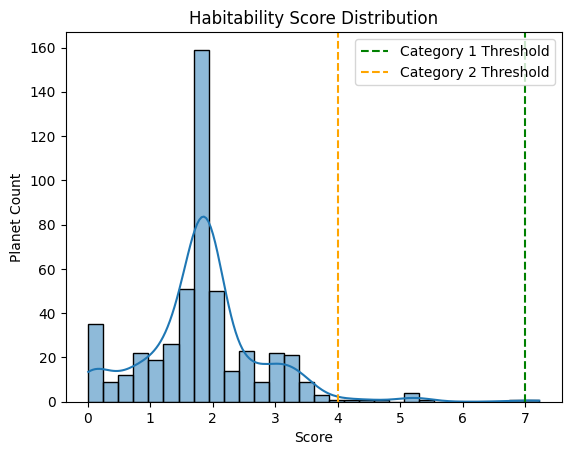

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['score'], bins=30, kde=True)
plt.axvline(7, color='green', linestyle='--', label='Category 1 Threshold')
plt.axvline(4, color='orange', linestyle='--', label='Category 2 Threshold')
plt.legend()
plt.title('Habitability Score Distribution')
plt.xlabel('Score')
plt.ylabel('Planet Count')
plt.show()


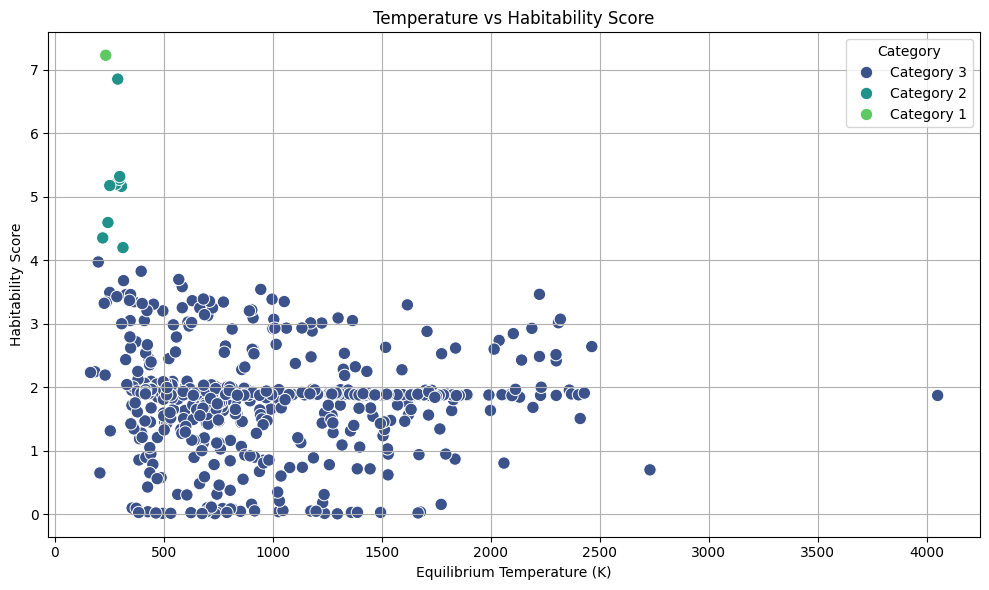

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pl_eqt', y='score', hue='habitability_category', palette='viridis', s=80)
plt.title('Temperature vs Habitability Score')
plt.xlabel('Equilibrium Temperature (K)')
plt.ylabel('Habitability Score')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-70-51387363>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top11, x='pl_name', y='score', palette='coolwarm', dodge=False)


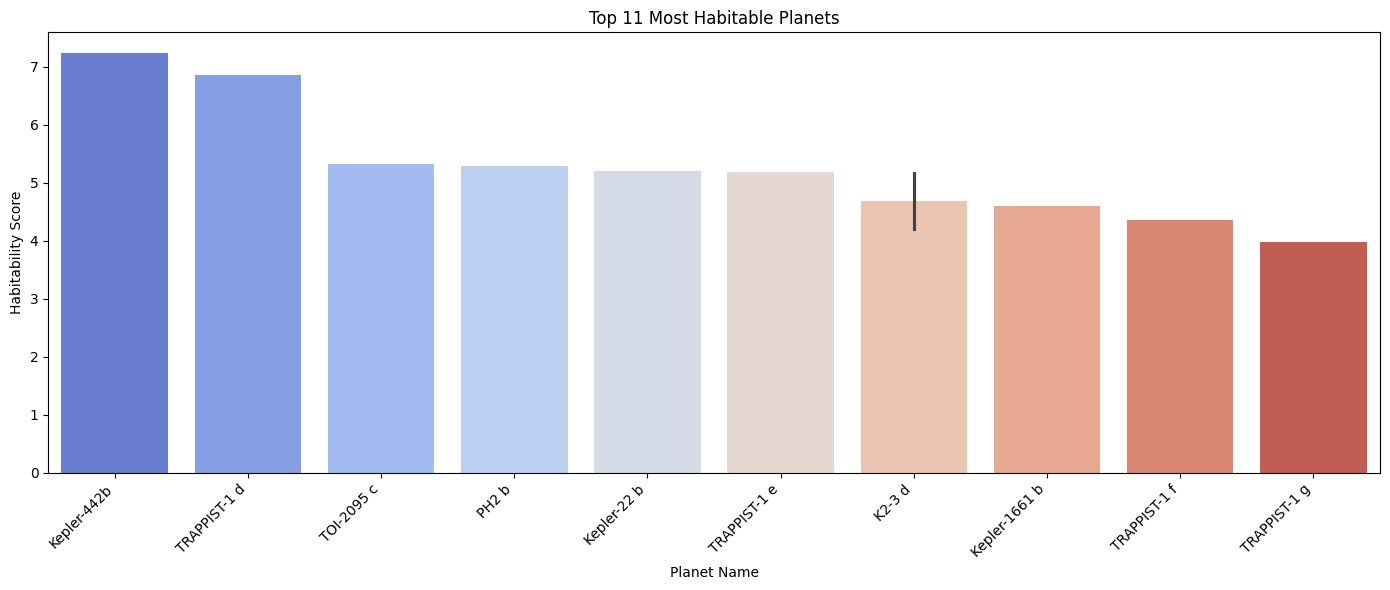

,pl_name,score,habitability_category
494,Kepler-442b,7.227602,Category 1
461,TRAPPIST-1 d,6.852420,Category 2
336,TOI-2095 c,5.319399,Category 2
267,PH2 b,5.276315,Category 2
221,Kepler-22 b,5.200925,Category 2
462,TRAPPIST-1 e,5.177653,Category 2
160,K2-3 d,5.164373,Category 2
211,Kepler-1661 b,4.595463,Category 2
463,TRAPPIST-1 f,4.352678,Category 2
161,K2-3 d,4.200375,Category 2


In [70]:
# Sort and get top 11
top11 = df.sort_values(by='score', ascending=False).head(11).copy()

# Ensure planet names are strings
top11['pl_name'] = top11['pl_name'].astype(str)

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=top11, x='pl_name', y='score', palette='coolwarm', dodge=False)

plt.title('Top 11 Most Habitable Planets')
plt.xlabel('Planet Name')
plt.ylabel('Habitability Score')
plt.xticks(rotation=45, ha='right')  # Rotate labels for clarity
plt.tight_layout()
plt.show()

# Display the table
top11[['pl_name', 'score', 'habitability_category']]


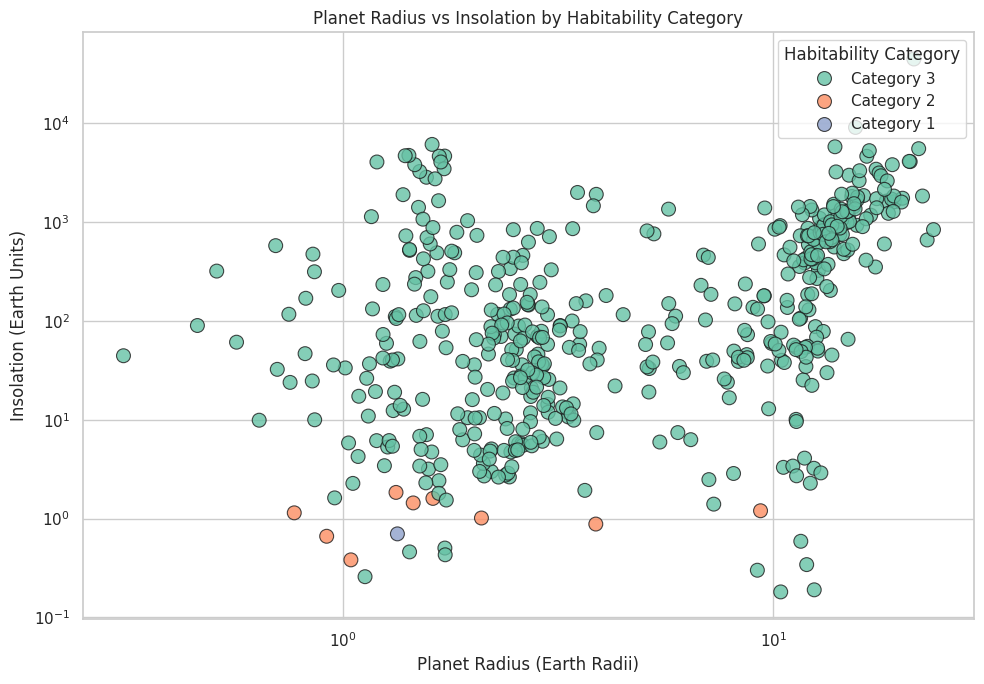

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame 'df' assumed to have columns:
# 'pl_rade' (planet radius), 'pl_insol' (insolation), 'habitability_category'

# If you haven't, load your dataset here
# df = pd.read_csv('your_dataset.csv')

# Filter to remove NaNs in radius or insolation
df_plot = df.dropna(subset=['pl_rade', 'pl_insol', 'habitability_category'])

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    data=df_plot,
    x='pl_rade',
    y='pl_insol',
    hue='habitability_category',
    palette='Set2',
    s=100,
    alpha=0.8,
    edgecolor='k'
)

plt.title('Planet Radius vs Insolation by Habitability Category')
plt.xlabel('Planet Radius (Earth Radii)')
plt.ylabel('Insolation (Earth Units)')
plt.xscale('log')  # Radius can vary widely, so log scale helps
plt.yscale('log')  # Insolation also varies a lot, log scale helps

plt.legend(title='Habitability Category', loc='upper right')
plt.tight_layout()
plt.show()


In [75]:
# Sort DataFrame by 'score' descending (highest to lowest)
top_100 = df.sort_values(by='score', ascending=False).head(100)

# Confirm it has 100 rows
print(f"Number of rows in top_100: {len(top_100)}")

# Save to CSV without index column
top_100.to_csv('top_100_habitability.csv', index=False)


Number of rows in top_100: 100


In [76]:
from google.colab import files
files.download('top_100_habitability.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>